In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
data_path = '../data/all_vacancies.csv'
df = pd.read_csv(data_path)
df.columns = ["x", "y", "z", "ion", "energy"]
grouped = df.groupby(["ion", "energy"])

In [3]:
from sklearn.model_selection import train_test_split
import torch

x_obs = []
theta = []

for (ion, energy), group in grouped:
    # group is a mini-DataFrame with all rows that share this ion + energy


    track = group[["x", "y", "z"]].values  # → shape (n_points, 3)

    # Summarize this track (e.g., mean and std of z)
    mean_x = np.mean(track[:, 0])
    std_x = np.std(track[:, 0])
    num_vac = track.shape[0]


    x_obs.append([mean_x, std_x, num_vac])  # Feature vector for this track
    theta.append([energy])  # Just using energy for now
    

In [4]:
x_obs = torch.tensor(x_obs, dtype=torch.float32)
theta = torch.tensor(theta, dtype=torch.float32)

In [5]:
from sklearn.model_selection import train_test_split

theta_np = theta.numpy()
x_obs_np = x_obs.numpy()

x_train, x_test, theta_train, theta_test = train_test_split(
    x_obs_np, theta_np, test_size=0.2, random_state=42
)

In [6]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
theta_train = torch.tensor(theta_train, dtype=torch.float32)
theta_test = torch.tensor(theta_test, dtype=torch.float32)

In [7]:
from sbi.utils import BoxUniform
import torch

low = torch.tensor([1000.0])
high = torch.tensor([2000000.0])

prior = BoxUniform(low, high)

/opt/homebrew/Caskroom/miniconda/base/envs/sbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sbi.inference import NPE
inference = NPE(prior=prior)

In [9]:
posterior_net = inference.append_simulations(theta_train, x_train).train()

/opt/homebrew/Caskroom/miniconda/base/envs/sbi/lib/python3.12/site-packages/sbi/neural_nets/net_builders/flow.py:149: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 250 epochs.

In [10]:
posterior = inference.build_posterior()

In [11]:
x0 = x_test[0:1]

In [13]:
samples = posterior.sample((1_000,), x0)


1107it [00:00, 57256.42it/s]            


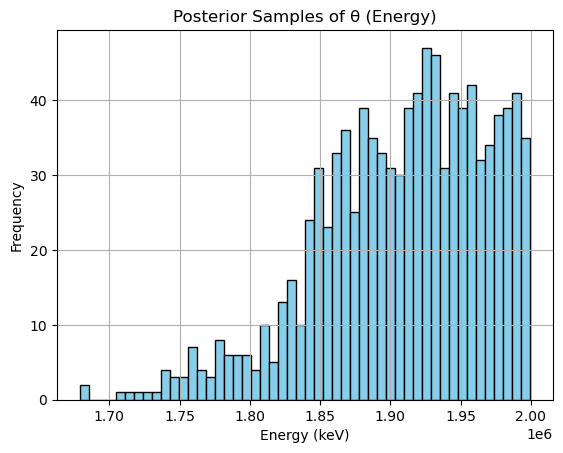

In [14]:
import matplotlib.pyplot as plt

samples_np = samples.numpy().squeeze()

plt.hist(samples_np, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Energy (keV)")
plt.ylabel("Frequency")
plt.title("Posterior Samples of θ (Energy)")
plt.grid(True)
plt.show() 

In [15]:
theta_point_estimate = samples.median().item()
print("Estimated energy (median):", theta_point_estimate)

Estimated energy (median): 1917287.25


In [21]:
theta0 = theta_test[0:1]
print('Energy:', theta0.item())

Energy: 2000000.0
